In [7]:
# Remember to turn on GPU!!!
# installing packages
!pip install keras --upgrade
!pip install tensorflow --upgrade
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install kaggle-cli

# Download our data straight from Kaggle
!kg download -u "user" -p "pass" -c data-science-bowl-2018 

# Unzip the files. -q option is for 'quiet' mode
!unzip -q stage1_train.zip -d stage1_train

# install cv2
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: pyyaml in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: tensorboard<1.7.0,>=1.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Require

stage1_train.zip 100% |#############################| Time: 0:00:02  38.0 MiB/s



In [8]:
!ls

datalab				  stage1_test.zip  stage1_train_labels.csv.zip
stage1_sample_submission.csv.zip  stage1_train	   stage1_train.zip


# Libraries and Global Parameters 

In [0]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten, Conv2DTranspose
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 1

#############################
#############################

model_checkpoint_file= 'unet_v' + str(model_num) +'.h5'
submission_filename = 'unet_v' + str(model_num) +'_pred.csv'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

# Preparing the Data

In [10]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
   # print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, images, filenames, dirs

train_X, train_images, train_filenames, train_dirs = import_images(train_root)

0.16090279665693347
0.24962165076888504
6.61494076761735e-16
1.0000000000000002
float64
float64


In [0]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 544


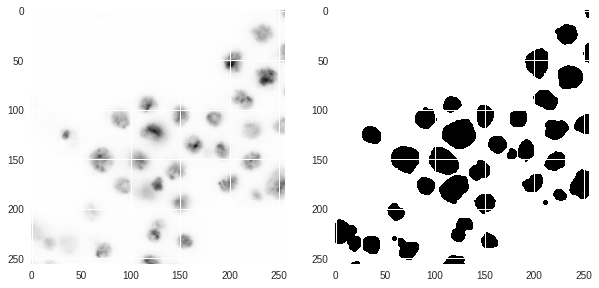

In [14]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(10,7))


In [15]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 518


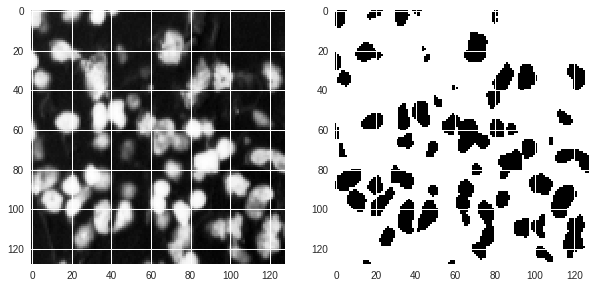

In [19]:
plot_check([np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3)],rand_imgs=1,size=(10,7))


# Now Let's Build the Model

In [28]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

  
  ## deprecated - used for meshnet
def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25,l2_reg=0):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate,kernel_regularizer=regularizers.l2(l2_reg)) (x)
    #x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x

  
def encoder(x, filters=44, n_block=3, kernel_size=(3, 3), activation='relu'):
    skip = []
    for i in range(n_block):
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        skip.append(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x, skip


def bottleneck(x, filters_bottleneck, mode='cascade', depth=6,
               kernel_size=(3, 3), activation='relu'):
    dilated_layers = []
    if mode == 'cascade':  # used in the competition
        for i in range(depth):
            x = Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            dilated_layers.append(x)
        return add(dilated_layers)
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        return add(dilated_layers)


def decoder(x, skip, filters, n_block=3, kernel_size=(3, 3), activation='relu'):
    for i in reversed(range(n_block)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = concatenate([skip[i], x])
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
    return x
  
  
def Unet(img_size):
    inputs = Input((img_size, img_size, img_channels))
    #s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)
    
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)
    
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)
    
    
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

  

## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout=0.2
):
    
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

#my_model = get_net(nb_filters=21,dropout=0.1,loss=binary_crossentropy)
my_model = Unet(img_height)
my_model.compile(optimizer=Adam(0.001), loss=binary_crossentropy, metrics=[bce_dice_loss, dice_coef])

############################################################################

print(my_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 128, 128, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 128, 128, 16) 0           conv2d_68[0][0]                  
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 128, 128, 16) 2320        dropout_33[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [29]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
596/603 [============================>.] - ETA: 2s - loss: 0.6002 - bce_dice_loss: 1.1380 - dice_coef: 0.5684

603/603 [==============================] - 191s 318ms/step - loss: 0.5961 - bce_dice_loss: 1.1324 - dice_coef: 0.5704 - val_loss: 0.8978 - val_bce_dice_loss: 1.4096 - val_dice_coef: 0.6187

Epoch 00001: val_loss improved from inf to 0.89777, saving model to unet_v1.h5
Epoch 2/100
251/603 [===========>..................] - ETA: 1:48 - loss: 0.2472 - bce_dice_loss: 0.6665 - dice_coef: 0.7004

603/603 [==============================] - 191s 316ms/step - loss: 0.2183 - bce_dice_loss: 0.6317 - dice_coef: 0.7020 - val_loss: 0.1742 - val_bce_dice_loss: 0.6240 - val_dice_coef: 0.7518

Epoch 00002: val_loss improved from 0.89777 to 0.17417, saving model to unet_v1.h5
Epoch 3/100
153/603 [======>.......................] - ETA: 2:19 - loss: 0.1644 - bce_dice_loss: 0.5255 - dice_coef: 0.7728

603/603 [==============================] - 192s 319ms/step - loss: 0.1637 - bce_dice_loss: 0.5284 - dice_coef: 0.7616 - val_loss: 0.1561 - val_bce_dice_loss: 0.4231 - val_dice_coef: 0.8060

Epoch 00003: val_loss improved from 0.17417 to 0.15608, saving model to unet_v1.h5
Epoch 4/100
125/603 [=====>........................] - ETA: 2:28 - loss: 0.1279 - bce_dice_loss: 0.4437 - dice_coef: 0.7987

603/603 [==============================] - 191s 317ms/step - loss: 0.1415 - bce_dice_loss: 0.4617 - dice_coef: 0.7946 - val_loss: 0.1347 - val_bce_dice_loss: 0.3920 - val_dice_coef: 0.8366

Epoch 00004: val_loss improved from 0.15608 to 0.13471, saving model to unet_v1.h5
Epoch 5/100
117/603 [====>.........................] - ETA: 2:28 - loss: 0.1396 - bce_dice_loss: 0.4544 - dice_coef: 0.8012

603/603 [==============================] - 188s 312ms/step - loss: 0.1312 - bce_dice_loss: 0.4258 - dice_coef: 0.8093 - val_loss: 0.1313 - val_bce_dice_loss: 0.3698 - val_dice_coef: 0.8233

Epoch 00005: val_loss improved from 0.13471 to 0.13128, saving model to unet_v1.h5
Epoch 6/100
115/603 [====>.........................] - ETA: 2:30 - loss: 0.1344 - bce_dice_loss: 0.4342 - dice_coef: 0.8014

603/603 [==============================] - 191s 316ms/step - loss: 0.1236 - bce_dice_loss: 0.4033 - dice_coef: 0.8189 - val_loss: 0.1137 - val_bce_dice_loss: 0.3482 - val_dice_coef: 0.8464

Epoch 00006: val_loss improved from 0.13128 to 0.11369, saving model to unet_v1.h5
Epoch 7/100
115/603 [====>.........................] - ETA: 2:29 - loss: 0.1128 - bce_dice_loss: 0.3656 - dice_coef: 0.8413

603/603 [==============================] - 191s 317ms/step - loss: 0.1156 - bce_dice_loss: 0.3750 - dice_coef: 0.8293 - val_loss: 0.1253 - val_bce_dice_loss: 0.4090 - val_dice_coef: 0.8246

Epoch 00007: val_loss did not improve
Epoch 8/100
129/603 [=====>........................] - ETA: 2:27 - loss: 0.1206 - bce_dice_loss: 0.4010 - dice_coef: 0.8135

603/603 [==============================] - 190s 315ms/step - loss: 0.1163 - bce_dice_loss: 0.3784 - dice_coef: 0.8274 - val_loss: 0.1103 - val_bce_dice_loss: 0.3527 - val_dice_coef: 0.8461

Epoch 00008: val_loss improved from 0.11369 to 0.11028, saving model to unet_v1.h5
Epoch 9/100
119/603 [====>.........................] - ETA: 2:26 - loss: 0.1071 - bce_dice_loss: 0.3530 - dice_coef: 0.8428

603/603 [==============================] - 188s 312ms/step - loss: 0.1128 - bce_dice_loss: 0.3633 - dice_coef: 0.8325 - val_loss: 0.1286 - val_bce_dice_loss: 0.3708 - val_dice_coef: 0.8402

Epoch 00009: val_loss did not improve
Epoch 10/100
130/603 [=====>........................] - ETA: 2:23 - loss: 0.1242 - bce_dice_loss: 0.3863 - dice_coef: 0.8219

524/603 [=========================>....] - ETA: 24s - loss: 0.1109 - bce_dice_loss: 0.3542 - dice_coef: 0.8364

KeyboardInterrupt: ignored

In [0]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

NameError: name 'results' is not defined

In [0]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


0.208730805725
0.293186881966
1.75073630806e-16
1.0
float64
float64
float64
65/65 [==============================] - 10s 156ms/step


Image #: 39


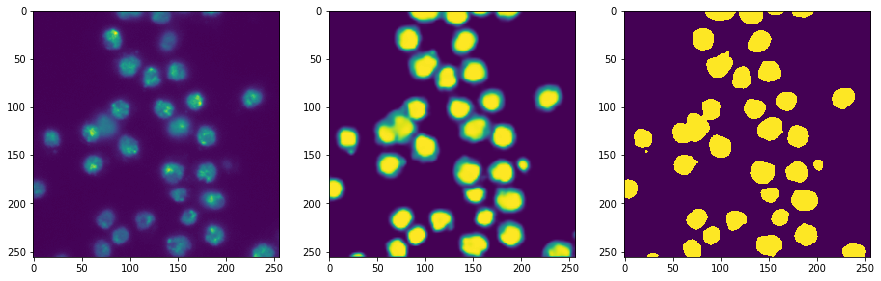

Image #: 58


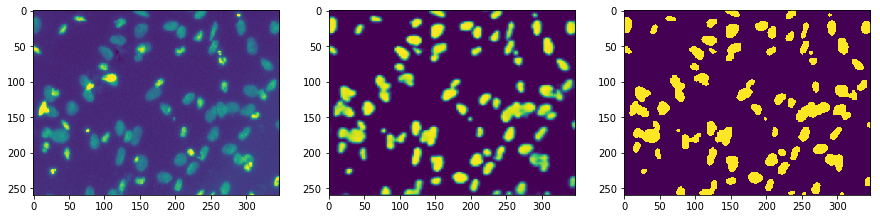

In [0]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [0]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data